In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

In [2]:
dataset = pd.read_csv("../data/preprocessed_movie_sentences.csv")

In [3]:
dataset.head()

,sentence,rating
0,smart alert thirteen conversation one thing sm...,0
1,color musical bounce warm sea lapping island s...,0
2,massmarket entertainment uncompromising attemp...,0
3,lighthearted french film spiritual quest fashi...,0
4,wife actress ha moment looking comic effect je...,0


In [4]:
dataset.groupby("rating").describe()

sentence                                                               
          count unique                                                top freq
rating                                                                        
0          5000   5000  even rare occasion narrator stop yammering mil...    1
1          5000   4998  friend may listen learn maybe never journey begin    2

0 for subjective, 1 for objective

In [5]:
dataset["n_words"] = dataset["sentence"].apply(lambda x: len(x.split()))

# SenticNet and POS tagging with spaCy

https://sentic.net/api/

In [6]:
from senticnet5 import senticnet

senticnet['concept_name'] = ['pleasantness_value', 'attention_value', 'sensitivity_value', 'aptitude_value', 'primary_mood', 'secondary_mood', 'polarity_label', 'polarity_value', 'semantics1', 'semantics2', 'semantics3', 'semantics4', 'semantics5']

In [7]:
# polarity value
senticnet['perfect'][7]

'0.867'

In [8]:
import spacy
nlp = spacy.load("en_core_web_sm")

https://spacy.io/usage/linguistic-features

token features:

token.text, token.lemma_, token.pos_, token.tag_, token.dep_, token.shape_, token.is_alpha, token.is_stop

In [9]:
def adj_polarity(sentence):
    doc = nlp(sentence)
    
    counter = 0
    total_value = 0
    for token in doc:
        if token.pos_ == "ADJ":
            counter += 1
            try:
                total_value += (float(senticnet[token.text][7])) ** 2
            except KeyError as err:
                # print(err) # want to note adjectives that aren't in SenticNet
                pass
            
    return counter, total_value

In [10]:
dataset["n_adj"], dataset["polarity_total"] = zip(*dataset["sentence"].apply(adj_polarity))

In [11]:
dataset["avg_polarity"] = dataset["polarity_total"] / dataset["n_adj"]
dataset["avg_polarity"].fillna(value=0, inplace=True)

In [12]:
dataset.head()

,sentence,rating,n_words,n_adj,polarity_total,avg_polarity
0,smart alert thirteen conversation one thing sm...,0,8,2,0.860341,0.430171
1,color musical bounce warm sea lapping island s...,0,13,3,0.770445,0.256815
2,massmarket entertainment uncompromising attemp...,0,8,0,0.000000,0.000000
3,lighthearted french film spiritual quest fashi...,0,15,2,0.025301,0.012650
4,wife actress ha moment looking comic effect je...,0,14,2,0.002809,0.001404


In [13]:
subj_samp = dataset[dataset["rating"] == 0]
obj_samp = dataset[dataset["rating"] == 1]

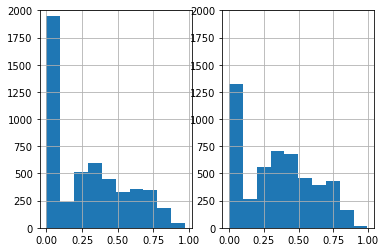

In [14]:
fig, axes = plt.subplots(1, 2)
axes[0].set(ylim=(0, 2000))
axes[1].set(ylim=(0, 2000))

obj_samp["avg_polarity"].hist(ax=axes[0])
subj_samp["avg_polarity"].hist(ax=axes[1])

Not a big difference.

In [15]:
neutral = dataset["avg_polarity"] <= 0.10
extreme = dataset["avg_polarity"] >= 0.80

# MPQA Subjectivity Lexicon

Words are classified as strongly subjective or weakly subjective.

In [16]:
mpqa = pd.read_csv("./subjclueslen1.csv", skipinitialspace=True)
mpqa.head()

,type,word,pos,stemmed,priorpolarity
0,weaksubj,abandoned,adj,n,negative
1,weaksubj,abandonment,noun,n,negative
2,weaksubj,abandon,verb,y,negative
3,strongsubj,abase,verb,y,negative
4,strongsubj,abasement,anypos,y,negative


In [17]:
mpqa.count()

type             8221
word             8221
pos              8221
stemmed          8221
priorpolarity    8221
dtype: int64

In [18]:
mpqa.word.nunique()

6886

In [19]:
def find_subj(sentence):
    doc = nlp(sentence)
    strong = 0
    weak = 0
    
    for token in doc:
        row = mpqa[(mpqa["word"] == token.text) & (mpqa["pos"] == token.pos_.lower())]
        if (row.type == "strongsubj").any():
            strong += 1
        elif (row.type == "weaksubj").any():
            weak += 1
            
    return strong, weak

In [20]:
dataset["strongsubj"], dataset["weaksubj"] = zip(*dataset["sentence"].apply(find_subj))

In [21]:
subj_samp = dataset[dataset["rating"] == 0]
obj_samp = dataset[dataset["rating"] == 1]

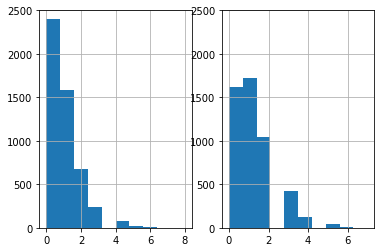

In [22]:
fig, axes = plt.subplots(1, 2)
axes[0].set(ylim=(0, 2500))
axes[1].set(ylim=(0, 2500))

obj_samp["strongsubj"].hist(ax=axes[0])
subj_samp["strongsubj"].hist(ax=axes[1])

# TFIDF

https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/

In [23]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

In [24]:
bow_vector = CountVectorizer(ngram_range=(1,1))
tfidf_vector = TfidfVectorizer()

In [25]:
X = dataset["sentence"]
labels = dataset["rating"]

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2)

In [26]:
# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

# Create pipeline using Bag of Words
pipe = Pipeline([('vectorizer', tfidf_vector), 
                 ('classifier', classifier)])

# model generation
pipe.fit(X_train, y_train)

C:\Users\lucy_\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [27]:
from sklearn import metrics
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression\n")
print("Accuracy:", metrics.accuracy_score(y_test, predicted))
print("Precision:",metrics.precision_score(y_test, predicted))
print("Recall:",metrics.recall_score(y_test, predicted))

Logistic Regression

Accuracy: 0.893
Precision: 0.8896761133603239
Recall: 0.8932926829268293


Will try other classifiers later.

# Adding features to the TFIDF matrix

In [28]:
tfidf_matrix = tfidf_vector.fit_transform(dataset["sentence"])

In [29]:
tfidf_matrix.shape

(10000, 20165)

In [30]:
from scipy.sparse import hstack

combined = hstack((tfidf_matrix, dataset.drop(["sentence", "rating"], axis=1)))
combined.shape

(10000, 20171)

In [31]:
X = combined
labels = dataset["rating"]

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2)

In [32]:
log = LogisticRegression()
log.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [33]:
predicted = log.predict(X_test)

# Model Accuracy
print("Logistic Regression\n")
print("Accuracy:", metrics.accuracy_score(y_test, predicted))
print("Precision:",metrics.precision_score(y_test, predicted))
print("Recall:",metrics.recall_score(y_test, predicted))

Logistic Regression

Accuracy: 0.8705
Precision: 0.8696969696969697
Recall: 0.8688193743693239


This actually seems to do a little worse? We need better-designed features.

# MLPRegressor

Not really sure how this works; just wanted to try something else.

In [34]:
from sklearn.neural_network import MLPRegressor

In [35]:
nn = MLPRegressor()
nn.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

(array([ 43., 233., 359., 271., 274., 299., 278., 175.,  60.,   8.]),
 array([-0.37837527, -0.18326588,  0.01184351,  0.2069529 ,  0.40206229,
         0.59717168,  0.79228107,  0.98739046,  1.18249984,  1.37760923,
         1.57271862]),
 <a list of 10 Patch objects>)

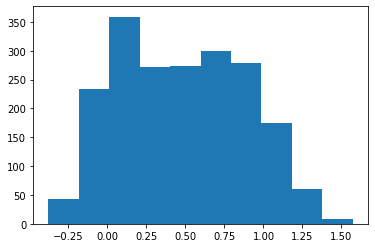

In [36]:
predicted = nn.predict(X_test)

plt.hist(predicted)

In [37]:
discrete = np.array([(xi >= 0.5) for xi in predicted])

In [38]:
print("Accuracy:", metrics.accuracy_score(y_test, discrete))

Accuracy: 0.8565
